# K Means Clustering Project For “Facebook Large Page-Page Network"

![title](Logo-default.jpg)

<hr>
<strong>Prepare by : Ibrahim Tahayna
<hr>
Supervision of: Prof. Giovanni Stilo
<hr>
course: Data Mining
</strong>

### Introduction
<hr>
This webgraph is a page-page graph of verified Facebook sites. Nodes represent official Facebook pages while the links are mutual likes between sites. Node features are extracted from the site descriptions that the page owners created to summarize the purpose of the site. This graph was collected through the Facebook Graph API in November 2017 and restricted to pages from 4 categories which are defined by Facebook. These categories are: politicians, governmental organizations, television shows and companies.



## Table of Contents

 1. <font color ='blue'>Import libraries
 2. Import dataset
 3. Data preprocessing 
 4. K-Means</font>

### 1. Import Libraries

In [1]:
# import required libraries for dataframe and visualization
import numpy as np  
import matplotlib.pyplot as plt 
import pandas as pd 
import json 
import seaborn as sns 

# import required libraries for clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

import networkx as nx


In [2]:
#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

### 2. Load Dataset 

In [3]:
#import the Csv file into DataFrame
e_df = pd.read_csv('musae_facebook_edges.csv')
#make sure that the data are int
e_df['id_1'] = e_df['id_1'].astype(int)
e_df['id_2'] = e_df['id_2'].astype(int)

# find which is the largest value in the id_1 and id_2 column to use it in new array of zeros 
n = max(max(e_df['id_1']),max(e_df['id_2']))+1

E = np.zeros((n, n))
#search for each column and raw and put 1 in the maching condition 
for row in e_df.itertuples(index=True, name='Pandas'):
    E[row[1]][row[2]]=1
    E[row[2]][row[1]]=1


In [4]:
E

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [38]:
e_df

,id_1,id_2
0,0,18427
1,1,21708
2,1,22208
3,1,22171
4,1,6829
...,...,...
170997,20188,20188
170998,22340,22383
170999,22348,22348
171000,5563,5563


In [39]:
#load the json file 
with open('musae_facebook_features.json') as json_data:
    features_dataframe = json.load(json_data)

# convert the json file into data frame the Data are the nodes 
fdf=pd.DataFrame(data=features_dataframe.items(), columns=['id_1','id_2']).explode(column='id_2')
fdf['id_1'] = fdf['id_1'].astype(int)
fdf['id_2'] = fdf['id_2'].astype(int)
#find the maximum id number between the nodes and the values to make DataFrame of zeros
p , q =  max(fdf['id_1'])+1 , max(fdf['id_2'])+1 
F = np.zeros((p,q))
for row in fdf.itertuples(index=True, name='Pandas'):
    F[row[1]][row[2]]=1



In [6]:
F

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
result = np.concatenate((E, F),axis=1)

In [40]:
result.shape

(22470, 27184)

## 3. Data Preprocessing

we used PCA to reduce the total size of the data.

The first line of the code contains the parameters "n_components" which states how many PCA components we want to project the dataset onto. Since we are going implement PCA with 2 components, therefore we set n_components = 2.

The second line of the code calls the "fit_transform" method, which fits the PCA model with the standardised data X_std and applies the dimensionality reduction on this dataset.

In [9]:
#Use Pipline module in order to use rescaling the attribute by MinMaxScaler and PCA to reduce the total size ofthe data.
preprocessor = Pipeline(
    [
        
        ("pca", PCA(n_components = 2, random_state=42)),
    ]
)

In [10]:
preprocessor.fit(result)

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=2,
                     random_state=42, svd_solver='auto', tol=0.0,
                     whiten=False))],
         verbose=False)

In [11]:
preprocessed_data = preprocessor.transform(result)

In [12]:
pcadf = pd.DataFrame(
    preprocessor.transform(result),
    columns=["components_1", "components_2"],
)



In [13]:
pcadf

,components_1,components_2
0,-0.399114,0.467592
1,0.283435,0.884792
2,-0.011409,-1.237683
3,-0.394336,0.506730
4,-0.486757,0.574659
...,...,...
22465,-0.385872,0.508067
22466,0.133493,0.262981
22467,-0.359306,0.547844
22468,-0.379940,0.513328


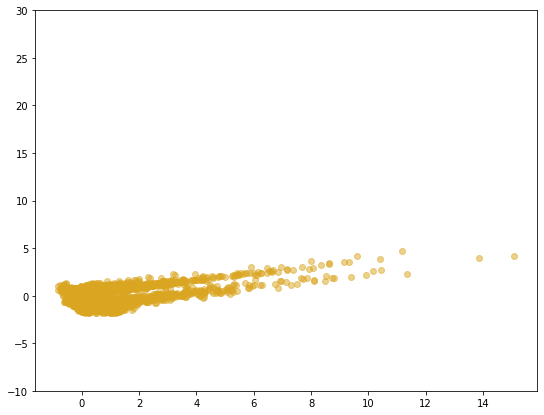

In [14]:
plt.figure(figsize = (9,7))
plt.scatter(pcadf.iloc[:,0],pcadf.iloc[:,1], c='goldenrod',alpha=0.5)
plt.ylim(-10,30)
plt.show()

It is extremely important to rescale the variables so that they have a comparable scale.here are two common ways of rescaling:

1. Min-Max scaling
2. Standardisation (mean-0, sigma-1)
Here, we will use Standardisation Scaling.

In [15]:
# Instantiate and fit_transform
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(pcadf)

### 4. K-Means model

The algorithm works as follows:

1. First we initialize k points, called means, randomly.
2. We categorize each item to its closest mean and we update the mean’s coordinates, which are the averages of the items categorized in that mean so far.
3. We repeat the process for a given number of iterations and at the end, we have our clusters.

### 4.1 Choise random  k 

In [16]:
# Run local implementation of kmeans
km = KMeans(n_clusters=2, max_iter=100)
km.fit(pcadf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

The k-means algorithm divides a set of N samples X into K disjoint clusters C, each described by the mean j of the samples in the cluster. The means are commonly called the cluster centroids.

In [17]:
centroids = km.cluster_centers_

In [18]:
centroids

array([[ 0.15969542, -0.81504372],
       [-0.10084013,  0.51466168]])

### 4.2 visulastion KMeans Cluster with centroids  

This graph shows the scatter plot of the data colored by the cluster they belong to.We chose K=5. The symbol ‘*‘ is the centroid of each cluster. We can think of those 5 clusters as geyser had different kinds of behaviors under different scenarios.

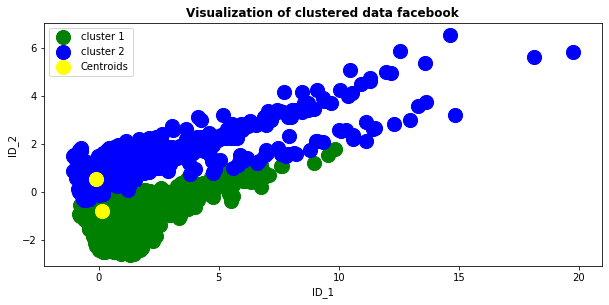

In [19]:
# Plot the clustered data
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(X_std[km.labels_ == 0, 0], X_std[km.labels_ == 0, 1],
            s=200, c='green', label='cluster 1')
plt.scatter(X_std[km.labels_ == 1, 0], X_std[km.labels_ == 1, 1], 
           s=200,c='blue', label='cluster 2')
#plt.scatter(X_std[km.labels_ == 2, 0], X_std[km.labels_ == 2, 1],
#          s=200,c='red', label='cluster 3')
#plt.scatter(X_std[km.labels_ == 3, 0], X_std[km.labels_ == 3, 1],
#         s=200,c='gray', label='cluster 4')
#plt.scatter(X_std[km.labels_ == 4, 0], X_std[km.labels_ == 4, 1],
#            s=200,c='black', label='cluster 5')
plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],s=200,c='yellow',label='Centroids')
plt.legend()
plt.xlabel('ID_1')
plt.ylabel('ID_2')
plt.title('Visualization of clustered data facebook', fontweight='bold')
ax.set_aspect('equal');

### 4.3 Use Silhouette method to find optimal number of clusters

Silhouette Analysis to get the right number of Clusters<hr>
The Silhouette Method is one of the most popular methods to determine this optimal value of k



<hr>

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mtext>silhouette score</mtext>
  <mo>=</mo>
  <mfrac>
    <mrow>
      <mi>p</mi>
      <mo>&#x2212;<!-- − --></mo>
      <mi>q</mi>
    </mrow>
    <mrow>
      <mi>m</mi>
      <mi>a</mi>
      <mi>x</mi>
      <mo stretchy="false">(</mo>
      <mi>p</mi>
      <mo>,</mo>
      <mi>q</mi>
      <mo stretchy="false">)</mo>
    </mrow>
  </mfrac>
</math>


p  is the mean distance to the points in the nearest cluster that the data point is not a part of

q is the mean intra-cluster distance to all the points in its own cluster.

    The value of the silhouette score range lies between -1 to 1.

    A score closer to 1 indicates that the data point is very similar to other data points in the cluster,

    A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [20]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

from sklearn.metrics import silhouette_score
silhouette_coefficients = []

# Notice we start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(pcadf)
    score = silhouette_score(pcadf, kmeans.labels_)
    silhouette_coefficients.append(score)
    print("For n_clusters={0}, the silhouette score is {1}".format(k, score))
  

For n_clusters=2, the silhouette score is 0.590363542531045
For n_clusters=3, the silhouette score is 0.6346438969652566
For n_clusters=4, the silhouette score is 0.6481041082563781
For n_clusters=5, the silhouette score is 0.6312152569315848
For n_clusters=6, the silhouette score is 0.6376740421522648
For n_clusters=7, the silhouette score is 0.6515512265765138
For n_clusters=8, the silhouette score is 0.6510174008330674
For n_clusters=9, the silhouette score is 0.6416251010106202
For n_clusters=10, the silhouette score is 0.6204330277482437


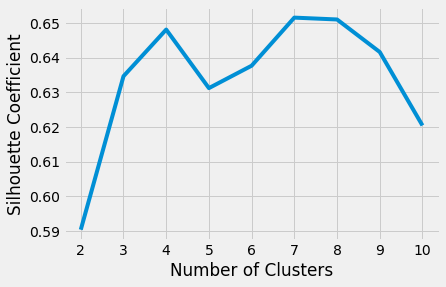

In [21]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

we see the best silhouette scoure is .648 when n_cluster = 4 and n_cluster = 7.

So wil implement when k = 4 and k =7.  then see  how cluster separetd in  graph 

In [22]:
km = KMeans(n_clusters=4, max_iter=100)
km.fit(pcadf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

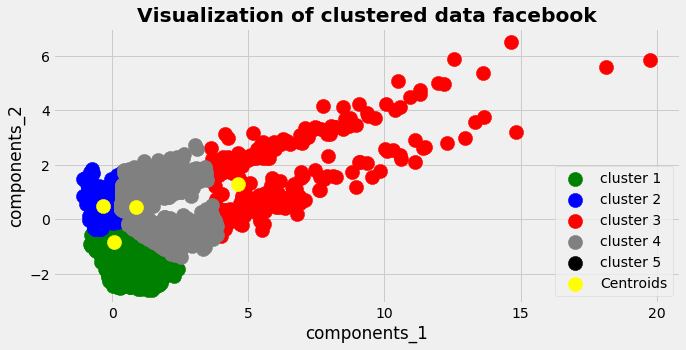

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(X_std[km.labels_ == 0, 0], X_std[km.labels_ == 0, 1],
            s=200, c='green', label='cluster 1')
plt.scatter(X_std[km.labels_ == 1, 0], X_std[km.labels_ == 1, 1], 
           s=200,c='blue', label='cluster 2')
plt.scatter(X_std[km.labels_ == 2, 0], X_std[km.labels_ == 2, 1],
          s=200,c='red', label='cluster 3')
plt.scatter(X_std[km.labels_ == 3, 0], X_std[km.labels_ == 3, 1],
          s=200,c='gray', label='cluster 4')
plt.scatter(X_std[km.labels_ == 4, 0], X_std[km.labels_ == 4, 1],
            s=200,c='black', label='cluster 5')
plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],s=200,c='yellow',label='Centroids')
plt.legend()
plt.xlabel('components_1')
plt.ylabel('components_2')
plt.title('Visualization of clustered data facebook', fontweight='bold')
ax.set_aspect('equal');

In [24]:
km = KMeans(n_clusters=7, max_iter=100)
km.fit(pcadf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

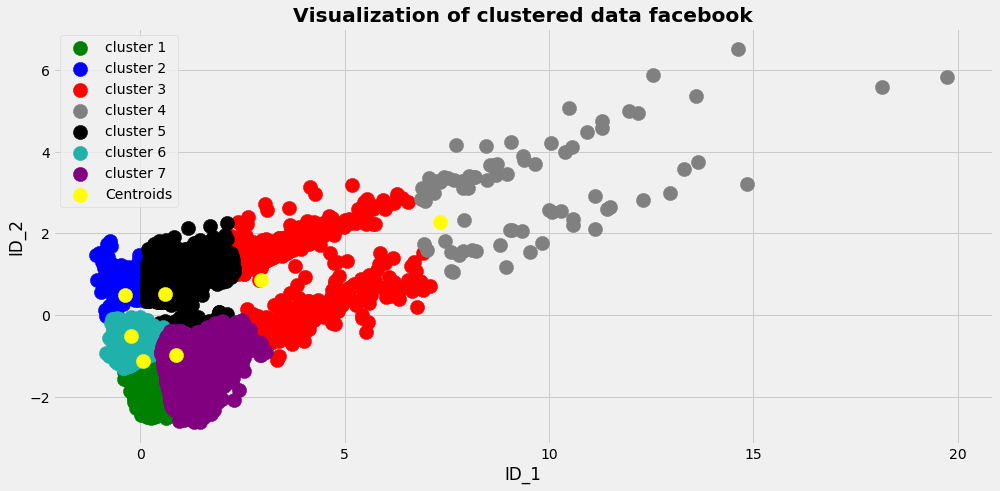

In [25]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.scatter(X_std[km.labels_ == 0, 0], X_std[km.labels_ == 0, 1],
            s=200, c='green', label='cluster 1')
plt.scatter(X_std[km.labels_ == 1, 0], X_std[km.labels_ == 1, 1], 
           s=200,c='blue', label='cluster 2')
plt.scatter(X_std[km.labels_ == 2, 0], X_std[km.labels_ == 2, 1],
          s=200,c='red', label='cluster 3')
plt.scatter(X_std[km.labels_ == 3, 0], X_std[km.labels_ == 3, 1],
          s=200,c='gray', label='cluster 4')
plt.scatter(X_std[km.labels_ == 4, 0], X_std[km.labels_ == 4, 1],
            s=200,c='black', label='cluster 5')
plt.scatter(X_std[km.labels_ == 5, 0], X_std[km.labels_ == 5, 1],
            s=200,c='LightSeaGreen', label='cluster 6')
plt.scatter(X_std[km.labels_ == 6, 0], X_std[km.labels_ == 6, 1],
            s=200,c='Purple', label='cluster 7')
plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],s=200,c='yellow',label='Centroids')
plt.legend()
plt.xlabel('ID_1')
plt.ylabel('ID_2')
plt.title('Visualization of clustered data facebook', fontweight='bold')
ax.set_aspect('equal')

**We can see from the two figures that clustring the data when k = 4 is better and more accurate than k = 7**


So we will choise k = 4.

### Cluster Analysis
<hr>
Here we choise k = 4 and load facebook target file, then add new column named cluster_label contain labels cluster when k = 4.

after that use groupby function btw cluster label and page type and make dataframe like pivot table in order to drow plot bar. 

In [26]:
km = KMeans(n_clusters=4, max_iter=100)
km.fit(pcadf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [27]:
clusters=km.labels_

In [29]:
clusters[:10]

array([2, 0, 3, 2, 2, 2, 3, 2, 2, 0])

In [30]:
target = pd.read_csv('musae_facebook_target.csv')

In [31]:
target['clusters_label']=clusters

In [32]:
target

,id,facebook_id,page_name,page_type,clusters_label
0,0,1.456470e+14,The Voice of China 中国好声音,tvshow,2
1,1,1.914830e+11,U.S. Consulate General Mumbai,government,0
2,2,1.447610e+14,ESET,company,3
3,3,5.687000e+14,Consulate General of Switzerland in Montreal,government,2
4,4,1.408940e+15,Mark Bailey MP - Labor for Miller,politician,2
...,...,...,...,...,...
22465,22465,1.379960e+15,Kurt Wiegel MdL,politician,2
22466,22466,1.651530e+15,dubdub Stories,company,2
22467,22467,1.553690e+14,Ministerio del Interior - Paraguay,government,2
22468,22468,1.750680e+14,Tottus Perú,company,2


In [33]:

full =target.groupby("clusters_label")["page_type"].value_counts()

In [34]:
full

clusters_label  page_type 
0               government    1678
                company        523
                tvshow         115
                politician     102
1               government     291
                company          4
2               government    4164
                politician    3071
                company       2724
                tvshow        1569
3               company       3244
                politician    2595
                tvshow        1643
                government     747
Name: page_type, dtype: int64

In [35]:
#returning a DataFrame having a new level of column labels whose inner-most level consists of the pivoted index labels.
dfpivo = full.unstack()


In [36]:
dfpivo

page_type,company,government,politician,tvshow
clusters_label,,,,
0,523.0,1678.0,102.0,115.0
1,4.0,291.0,NaN,NaN
2,2724.0,4164.0,3071.0,1569.0
3,3244.0,747.0,2595.0,1643.0


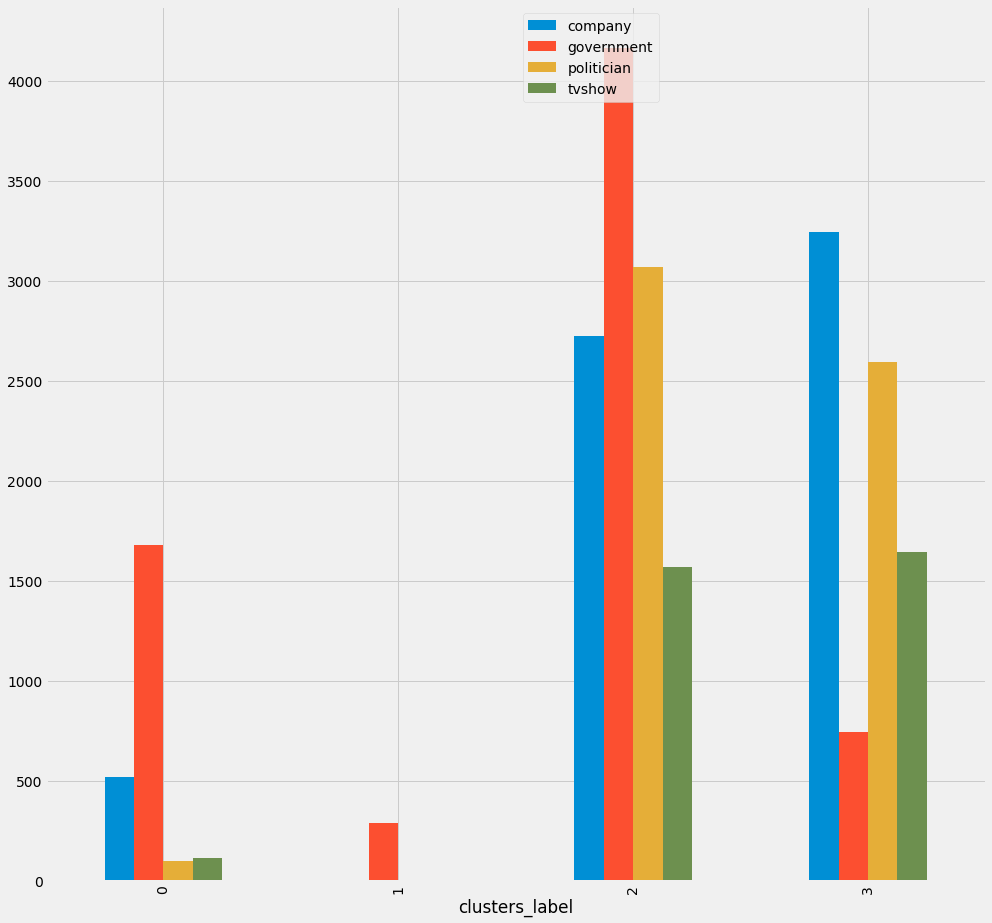

In [37]:
dfpivo.plot.bar(figsize=(15, 15))
#dfp.plot.bar(stacked=True)
#plt.style.use('seaborn')
plt.legend(bbox_to_anchor=(.5, 1), loc='upper left')

### Description of the Clusters

<hr>
<strong>
    
Cluster 0:

this cluster with 2416 pages and the largest page types is government and companies with 9% percent of the data and that mean that these pages only likes government pages and company pages.
    
Cluster 1:

It is the smallest cluster and contains only likes on government pages 291 and very few company pages with 4 likes.  
    
Cluster 2:

Witch is the largest cluster and the type of page larger government by 36% and 26% of page Political and 23% type of pages companies and 15% of the type of program pages television.


Cluster 3: 

It is the second largest cluster witch and the biggest page type is the company with 39% and so likes 31% of the political page genre, 19% of the TV programs and 11% of the government type.



Note that cluster 1 and cluster 2 can be considered one group.

We can also improve the analysis if there are more features such as the region or country of these pages.
</strong>